# Primer ejemplo de minería de procesos

En este cuaderno, vamos a:
- Cargar con pandas un archivo de eventos
- Preparar el archivo para su procesamiento por pm4py
- Cargar el archivo en pm4py
- Vamos a hacer discovering de procesos
- Vamos a identificar los potenciales cuellos de botella o áreas de mejora.

A por ello!

In [81]:
# Importaciones que necesitamos:
import pandas as pd
from pm4py.objects.conversion.log import converter

from pm4py.algo.discovery.inductive import algorithm as inductive_miner

from pm4py.objects.conversion.process_tree.variants import to_bpmn as conversor_a_bpmn
from pm4py.objects.conversion.process_tree import converter as conversor_a_petri

from pm4py.visualization.process_tree import visualizer as visualizador_de_process_trees
from pm4py.visualization.petri_net import visualizer as visualizador_redes_de_petri
from pm4py.visualization.bpmn import visualizer as visualizador_de_bpmn

from pm4py.objects.bpmn.exporter import exporter as exportador_a_bpmn


Lo primero que haremos será cargar con pandas el archivo de eventos.

In [82]:
datos = pd.read_csv('datos.csv', parse_dates=['timestamp'])
datos

,case_id,activity,timestamp,resource
0,1001,Pedido recibido,2025-06-01 09:00:00,Ana
1,1001,Validación,2025-06-01 10:00:00,Pedro
2,1001,Aprobación,2025-06-01 11:30:00,Juan
3,1002,Pedido recibido,2025-06-01 09:15:00,Ana
4,1002,Rechazo,2025-06-01 09:45:00,Marta


In [83]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   case_id    5 non-null      int64         
 1   activity   5 non-null      object        
 2   timestamp  5 non-null      datetime64[ns]
 3   resource   5 non-null      object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 288.0+ bytes


In [84]:
datos.describe()

,case_id,timestamp
count,5.000000,5
mean,1001.400000,2025-06-01 09:54:00
min,1001.000000,2025-06-01 09:00:00
25%,1001.000000,2025-06-01 09:15:00
50%,1001.000000,2025-06-01 09:45:00
75%,1002.000000,2025-06-01 10:00:00
max,1002.000000,2025-06-01 11:30:00
std,0.547723,NaN


Cambiamos los nombres de las columnas a los que necesita pm4py. Además aprovechamos para ordenar las columnas de forma que queden como las necesita pm4py.

In [121]:
# Renombra las columnas para que pm4py las entienda
datos_preparados = datos.rename(columns={
    'case_id': 'case:concept:name',
    'activity': 'concept:name',
    'timestamp': 'time:timestamp'
})  
# Ordenar por caso y por fecha
datos_renombrados = datos_preparados.sort_values(by=['case:concept:name', 'time:timestamp'])  # Ordena los datos por case_id y timestamp

datos_preparados 

,case:concept:name,concept:name,time:timestamp,resource
0,1001,Pedido recibido,2025-06-01 09:00:00,Ana
1,1001,Validación,2025-06-01 10:00:00,Pedro
2,1001,Aprobación,2025-06-01 11:30:00,Juan
3,1002,Pedido recibido,2025-06-01 09:15:00,Ana
4,1002,Rechazo,2025-06-01 09:45:00,Marta


Le pido a la librería que cargue el DataFrame y lo transforme en un objeto de tipo Event Log.

Un event log es un objeto propio de la librería pm4py que contiene los datos del DataFrame en un formato adecuado para el análisis de procesos.

In [86]:
log = converter.apply(datos_preparados, variant = converter.Variants.TO_EVENT_LOG)  # Convierte los datos a un log de eventos de pm4py
log

[{'attributes': {'concept:name': 1001}, 'events': [{'concept:name': 'Pedido recibido', 'time:timestamp': Timestamp('2025-06-01 09:00:00'), 'resource': 'Ana'}, '..', {'concept:name': 'Aprobación', 'time:timestamp': Timestamp('2025-06-01 11:30:00'), 'resource': 'Juan'}]}, '....', {'attributes': {'concept:name': 1002}, 'events': [{'concept:name': 'Pedido recibido', 'time:timestamp': Timestamp('2025-06-01 09:15:00'), 'resource': 'Ana'}, '..', {'concept:name': 'Rechazo', 'time:timestamp': Timestamp('2025-06-01 09:45:00'), 'resource': 'Marta'}]}]

Lo que vemos ahí es un formato raro (de listas y diccionarios) en el que pm4py prepara los datos para posteriormente poder analizarlos.B

Básicamente, los agrupa por CASO.

Ese formato interno nos da igual verlo por pantalla... solo es algo que hay que hacer.

Una vez hecho esto, lo que vamos a hacer es generar un modelo, a partir de los datos que hemos cargado, para ver cómo es el proceso.

La forma más básica de modelo que tiene pm4py es lo que se llama un PROCESS TREE.

Eso es algo muy formal... y que cuando lo miro, flipo!... pero es la descripción matemática formal del modelo de proceso, al que se ajustan TODAS las entradas del log de eventos.

In [87]:
# Estamos usando un algoritmo de mineria de procesos, llamado Inductive Miner, para descubrir el modelo de proceso a partir del log de eventos.
# Hay muchos más algoritmos. Ya os pasaré una lista.
process_tree = inductive_miner.apply(log)  # Aplica el algoritmo de descubrimiento inductivo a los datos

process_tree


->( 'Pedido recibido', X( ->( 'Validación', 'Aprobación' ), 'Rechazo' ) )

Ahí podemos llegar a ver los siguientes operadores:

-> SECUENCIA: indica que una actividad(es) sigue a otra.

X  ALTERNATIVA: indica que una actividad(es) u otra puede ocurrir.

^  AND: Tareas que se ejecutan en paralelo.

⟳ ITERACIÓN: indica que una actividad(es) puede repetirse.


    SECUENCIA
    - Pedido recibido
    - ALTERNATIVA
        - SECUENCIA
            - Validación
            - Aprobación
        - Rechazo

Esta representación es muy buena para el posterior análsis de los datos. Cuando digo muy buena, me refiero a que COMPUTACIONALMENTE ES MUY FÁCIL RECORRER ESE ÁRBOL e ir PROBANDO los datos que tenemos en el fichero de los... a ver si encajan o no con  ese árbol. ESO ES ALGO QUE HACE INTERNAMENTE LA LIBRERÍA PM4PY.

Lo que hacemos posteriormente es transformar ese process_tree en algo que nosotros podamos ver y entender mejor: un diagrama de RED DE PETRI o un diagrama BPMN.

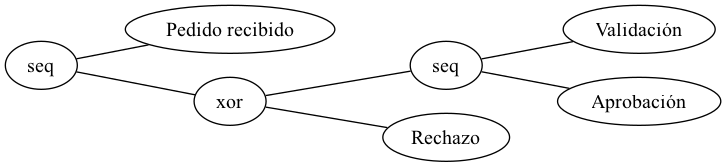

In [88]:
grafico_process_tree = visualizador_de_process_trees.apply(process_tree, parameters={"format": "png"})
visualizador_de_process_trees.save(grafico_process_tree,"process_tree.png")
visualizador_de_process_trees.view(grafico_process_tree)

Ese árbol de procesos está guay para PM4PY.. no para mi. Vamos a generar una red de petri, que podemos representar en algo que lleva un flujo!

In [89]:
red, origenes, finales = conversor_a_petri.apply(process_tree)  # Convierte el árbol de procesos a una red de Petri
red


places: [ p_3, p_4, sink, source ]
transitions: [ (005af996-8466-4b56-9e9d-a10f06bbaba4, 'Aprobación'), (089576a9-4220-4a43-a3ff-f45f9de8d8b8, 'Rechazo'), (463edb21-1e71-437f-b3a0-1e5b3302eb6a, 'Validación'), (5ac4365b-a2e8-45c8-b1df-54b418a6a8f8, 'Pedido recibido') ]
arcs: [ (005af996-8466-4b56-9e9d-a10f06bbaba4, 'Aprobación')->sink, (089576a9-4220-4a43-a3ff-f45f9de8d8b8, 'Rechazo')->sink, (463edb21-1e71-437f-b3a0-1e5b3302eb6a, 'Validación')->p_4, (5ac4365b-a2e8-45c8-b1df-54b418a6a8f8, 'Pedido recibido')->p_3, p_3->(089576a9-4220-4a43-a3ff-f45f9de8d8b8, 'Rechazo'), p_3->(463edb21-1e71-437f-b3a0-1e5b3302eb6a, 'Validación'), p_4->(005af996-8466-4b56-9e9d-a10f06bbaba4, 'Aprobación'), source->(5ac4365b-a2e8-45c8-b1df-54b418a6a8f8, 'Pedido recibido') ]

In [90]:
origenes

['source:1']

In [91]:
finales

['sink:1']

Ahora tenemos una red de petri. Lo que vemos en pantalla es la representación INTERNA que se hace de esa red de petri... pero para verla, nos interesa más que se nos dibuje como un grafo:

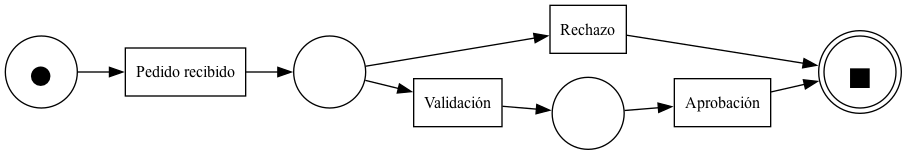

In [92]:

grafico_red_petri = visualizador_redes_de_petri.apply(red, origenes, finales, parameters={"format": "png"})  # Visualiza la red de Petri resultante del descubrimiento

visualizador_redes_de_petri.save(grafico_red_petri, "proceso.png")  # Guarda la visualización en un fichero PNG
visualizador_redes_de_petri.view(grafico_red_petri)

Igual que hemos generado un modelo PETRI del proceso, podemos generar un modelo BPMN del proceso.
Vamos a generar un modelo BPMN del proceso. 
Ese modelo posteriormente lo podemos:
- Representar gráficamente en algo más fácil de entender para los humanos.
- Exportarlo a un fichero XML que se puede importar en herramientas de modelado de procesos industriales.

In [93]:
modelo_bpmn = conversor_a_bpmn.apply(process_tree)  # Convierte el árbol de procesos a una red de Petri
modelo_bpmn

Ahora que ya tengo el modelo podemos guardarlo como xml:

In [94]:
exportador_a_bpmn.apply(modelo_bpmn, "proceso.bpmn")  # Exporta el modelo BPMN a un fichero XML

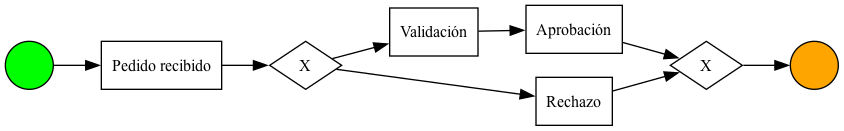

In [95]:

grafico_bpmn = visualizador_de_bpmn.apply(modelo_bpmn, parameters={"format": "png"})  # Visualiza la red de Petri resultante del descubrimiento

visualizador_de_bpmn.save(grafico_bpmn, "proceso-bpmn.png")  # Guarda la visualización en un fichero PNG
visualizador_de_bpmn.view(grafico_bpmn) # Lo muestra aqui en pantalla

## Estadísticas del Log de Eventos

Una vez que hemos generado el modelo del proceso, es importante analizar las estadísticas del log de eventos para entender mejor las características del proceso.

In [96]:
# Importamos librerías adicionales para estadísticas
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.statistics.traces.generic.log import case_arrival
from pm4py.statistics.attributes.log import get as get_attribute_values
import numpy as np

In [97]:
# Estadísticas básicas del log
print("=== ESTADÍSTICAS BÁSICAS DEL LOG ===")
print(f"Número total de casos: {len(log)}")
print(f"Número total de eventos: {sum(len(trace) for trace in log)}")

# Longitud de las trazas
longitudes_trazas = [len(trace) for trace in log]
print(f"Longitud media de traza: {np.mean(longitudes_trazas):.2f}")
print(f"Longitud mínima de traza: {min(longitudes_trazas)}")
print(f"Longitud máxima de traza: {max(longitudes_trazas)}")
print(f"Desviación estándar longitud: {np.std(longitudes_trazas):.2f}")

=== ESTADÍSTICAS BÁSICAS DEL LOG ===
Número total de casos: 2
Número total de eventos: 5
Longitud media de traza: 2.50
Longitud mínima de traza: 2
Longitud máxima de traza: 3
Desviación estándar longitud: 0.50


In [98]:
# Estadísticas de actividades
print("\n=== ESTADÍSTICAS DE ACTIVIDADES ===")
actividades = get_attribute_values.get_attribute_values(log, "concept:name")
print(f"Número de actividades únicas: {len(actividades)}")
print("\nFrecuencia de actividades:")
for actividad, frecuencia in sorted(actividades.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {actividad}: {frecuencia} eventos")


=== ESTADÍSTICAS DE ACTIVIDADES ===
Número de actividades únicas: 4

Frecuencia de actividades:
  - Pedido recibido: 2 eventos
  - Validación: 1 eventos
  - Aprobación: 1 eventos
  - Rechazo: 1 eventos


In [99]:
# Estadísticas de variantes del proceso
print("\n=== VARIANTES DEL PROCESO ===")
variantes = {}
for trace in log:
    variante = tuple([event["concept:name"] for event in trace])
    if variante in variantes:
        variantes[variante] += 1
    else:
        variantes[variante] = 1

print(f"Número de variantes únicas: {len(variantes)}")
print(f"Variante más común: {max(variantes, key=variantes.get)} (aparece {max(variantes.values())} veces)")

print("\nTop 5 variantes más frecuentes:")
for i, (variante, frecuencia) in enumerate(sorted(variantes.items(), key=lambda x: x[1], reverse=True)[:5]):
    print(f"  {i+1}. {' → '.join(variante)} ({frecuencia} casos)")


=== VARIANTES DEL PROCESO ===
Número de variantes únicas: 2
Variante más común: ('Pedido recibido', 'Validación', 'Aprobación') (aparece 1 veces)

Top 5 variantes más frecuentes:
  1. Pedido recibido → Validación → Aprobación (1 casos)
  2. Pedido recibido → Rechazo (1 casos)


In [100]:
# Análisis de actividades iniciales y finales (VERSIÓN OPTIMIZADA)
print("\n=== ACTIVIDADES INICIALES Y FINALES ===")

# Importar las funciones nativas de PM4py
from pm4py.statistics.start_activities.log import get as sa_get
from pm4py.statistics.end_activities.log import get as ea_get

# Obtener actividades iniciales usando funciones nativas
actividades_iniciales = sa_get.get_start_activities(log)
print("Actividades iniciales:")
for actividad, frecuencia in sorted(actividades_iniciales.items(), key=lambda x: x[1], reverse=True):
    porcentaje = (frecuencia / len(log)) * 100
    print(f"  - {actividad}: {frecuencia} casos ({porcentaje:.1f}%)")

# Obtener actividades finales usando funciones nativas
actividades_finales = ea_get.get_end_activities(log)
print("\nActividades finales:")
for actividad, frecuencia in sorted(actividades_finales.items(), key=lambda x: x[1], reverse=True):
    porcentaje = (frecuencia / len(log)) * 100
    print(f"  - {actividad}: {frecuencia} casos ({porcentaje:.1f}%)")

# Estadísticas adicionales
print(f"\nNúmero de actividades iniciales únicas: {len(actividades_iniciales)}")
print(f"Número de actividades finales únicas: {len(actividades_finales)}")

# Actividades que son tanto iniciales como finales
actividades_ambas = set(actividades_iniciales.keys()) & set(actividades_finales.keys())
if actividades_ambas:
    print(f"\nActividades que pueden ser tanto iniciales como finales: {list(actividades_ambas)}")
else:
    print("\nNo hay actividades que sean tanto iniciales como finales")


=== ACTIVIDADES INICIALES Y FINALES ===
Actividades iniciales:
  - Pedido recibido: 2 casos (100.0%)

Actividades finales:
  - Aprobación: 1 casos (50.0%)
  - Rechazo: 1 casos (50.0%)

Número de actividades iniciales únicas: 1
Número de actividades finales únicas: 2

No hay actividades que sean tanto iniciales como finales


In [101]:
# Análisis temporal
print("\n=== ANÁLISIS TEMPORAL ===")

# Duración de casos (si hay timestamps)
if len(log) > 0 and len(log[0]) > 0 and "time:timestamp" in log[0][0]:
    duraciones = []
    for trace in log:
        if len(trace) > 1:
            inicio = trace[0]["time:timestamp"]
            fin = trace[-1]["time:timestamp"]
            duracion = (fin - inicio).total_seconds() / 3600  # en horas
            duraciones.append(duracion)
    
    if duraciones:
        print(f"Duración media del proceso: {np.mean(duraciones):.2f} horas")
        print(f"Duración mínima: {min(duraciones):.2f} horas")
        print(f"Duración máxima: {max(duraciones):.2f} horas")
        print(f"Mediana de duración: {np.median(duraciones):.2f} horas")
else:
    print("No hay información temporal disponible en el log")


=== ANÁLISIS TEMPORAL ===
Duración media del proceso: 1.50 horas
Duración mínima: 0.50 horas
Duración máxima: 2.50 horas
Mediana de duración: 1.50 horas


In [102]:
# Calidad de los datos
print("\n=== CALIDAD DE LOS DATOS ===")

# Verificar casos vacíos
casos_vacios = sum(1 for trace in log if len(trace) == 0)
print(f"Casos vacíos: {casos_vacios}")

# Verificar eventos sin actividad
eventos_sin_actividad = 0
for trace in log:
    for event in trace:
        if "concept:name" not in event or event["concept:name"] is None or event["concept:name"] == "":
            eventos_sin_actividad += 1

print(f"Eventos sin nombre de actividad: {eventos_sin_actividad}")

# Casos con una sola actividad
casos_unitarios = sum(1 for trace in log if len(trace) == 1)
print(f"Casos con una sola actividad: {casos_unitarios}")

print(f"\nPorcentaje de casos 'normales' (>1 actividad): {((len(log) - casos_vacios - casos_unitarios) / len(log) * 100):.1f}%")


=== CALIDAD DE LOS DATOS ===
Casos vacíos: 0
Eventos sin nombre de actividad: 0
Casos con una sola actividad: 0

Porcentaje de casos 'normales' (>1 actividad): 100.0%


## Evaluación de la Calidad de los Modelos (Fitness)

El fitness mide qué tan bien el modelo descubierto puede reproducir el comportamiento observado en el log de eventos. Un fitness de 1.0 significa que el modelo puede reproducir perfectamente todas las trazas del log.

In [103]:
# Importamos las librerías necesarias para calcular el fitness
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

In [ ]:
# Evaluación del modelo de Petri
print("=== EVALUACIÓN DEL MODELO DE PETRI ===")

# Fitness: mide qué tan bien el modelo puede reproducir las trazas del log
fitness_petri = replay_fitness_evaluator.apply(log, red, origenes, finales, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"Fitness (Token-based): {fitness_petri['log_fitness']:.4f}")
print(f"Porcentaje de trazas que encajan perfectamente: {fitness_petri['percentage_of_fitting_traces']:.2f}%")

# Precisión: mide cuánto comportamiento adicional permite el modelo que no está en el log
try:
    precision_petri = precision_evaluator.apply(log, red, origenes, finales, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    print(f"Precisión: {precision_petri:.4f}")
except:
    print("No se pudo calcular la precisión para este modelo")

# Generalización: mide la capacidad del modelo para generalizar más allá del log observado
try:
    generalization_petri = generalization_evaluator.apply(log, red, origenes, finales)
    print(f"Generalización: {generalization_petri:.4f}")
except:
    print("No se pudo calcular la generalización para este modelo")

# Simplicidad: mide la complejidad del modelo
try:
    simplicity_petri = simplicity_evaluator.apply(red)
    print(f"Simplicidad: {simplicidad_petri:.4f}")
except:
    print("No se pudo calcular la simplicidad para este modelo")

=== EVALUACIÓN DEL MODELO DE PETRI ===


replaying log with TBR, completed traces :: 100%|██████████| 2/2 [00:00<00:00, 2774.01it/s]


Fitness (Token-based): 1.0000
Porcentaje de trazas que encajan perfectamente: 100.00%


replaying log with TBR, completed traces :: 100%|██████████| 2/2 [00:00<00:00, 3436.55it/s]


Precisión: 1.0000


replaying log with TBR, completed traces :: 100%|██████████| 2/2 [00:00<00:00, 3067.13it/s]

Generalización: 0.0732
Simplicidad: 1.0000


In [105]:
# Evaluación del modelo BPMN (convertimos primero a Petri para la evaluación)
print("\n=== EVALUACIÓN DEL MODELO BPMN ===")

# Para evaluar BPMN, primero lo convertimos a red de Petri
from pm4py.objects.conversion.bpmn import converter as bpmn_converter
try:
    red_desde_bpmn, origenes_bpmn, finales_bpmn = bpmn_converter.apply(modelo_bpmn, variant=bpmn_converter.Variants.TO_PETRI_NET)
    
    # Fitness del modelo BPMN
    fitness_bpmn = replay_fitness_evaluator.apply(log, red_desde_bpmn, origenes_bpmn, finales_bpmn, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
    print(f"Fitness (Token-based): {fitness_bpmn['log_fitness']:.4f}")
    print(f"Porcentaje de trazas que encajan perfectamente: {fitness_bpmn['percentage_of_fitting_traces']:.2f}%")
    
    # Precisión del modelo BPMN
    try:
        precision_bpmn = precision_evaluator.apply(log, red_desde_bpmn, origenes_bpmn, finales_bpmn, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        print(f"Precisión: {precision_bpmn:.4f}")
    except:
        print("No se pudo calcular la precisión para el modelo BPMN")
    
except Exception as e:
    print(f"Error al evaluar el modelo BPMN: {e}")
    print("Nota: Los modelos Petri y BPMN generados del mismo process tree deberían tener métricas similares")


=== EVALUACIÓN DEL MODELO BPMN ===


replaying log with TBR, completed traces :: 100%|██████████| 2/2 [00:00<00:00, 2181.13it/s]


Fitness (Token-based): 1.0000
Porcentaje de trazas que encajan perfectamente: 100.00%


replaying log with TBR, completed traces :: 100%|██████████| 2/2 [00:00<00:00, 3656.76it/s]

Precisión: 1.0000


### Interpretación de las Métricas de Calidad

- **Fitness (0-1)**: Mide qué tan bien el modelo puede reproducir las trazas del log. 1.0 = perfecto.
- **Precisión (0-1)**: Mide cuánto comportamiento "extra" permite el modelo que no aparece en el log. Valores altos = modelo más preciso.
- **Generalización (0-1)**: Mide la capacidad del modelo para manejar comportamiento no visto. Valores altos = mejor generalización.
- **Simplicidad (0-1)**: Mide la complejidad del modelo. Valores altos = modelo más simple.

**Balance ideal**: Un buen modelo de proceso debe tener altos valores en las cuatro dimensiones, aunque a menudo hay trade-offs entre ellas.

In [106]:
# Análisis detallado de conformidad - casos que no encajan
print("\n=== ANÁLISIS DETALLADO DE CONFORMIDAD ===")

if fitness_petri['log_fitness'] < 1.0:
    print(f"El modelo tiene un fitness de {fitness_petri['log_fitness']:.4f}, lo que significa que no todas las trazas encajan perfectamente.")
    print(f"Número de trazas que no encajan: {len(log) - int(len(log) * fitness_petri['percentage_of_fitting_traces'] / 100)}")
    
    # Mostrar algunas trazas problemáticas si las hay
    print("\nEsto puede indicar:")
    print("- Ruido en los datos")
    print("- Comportamiento excepcional no capturado por el modelo")
    print("- Necesidad de usar un algoritmo de descubrimiento diferente")
else:
    print("¡Excelente! El modelo tiene un fitness perfecto de 1.0")
    print("Todas las trazas del log pueden ser reproducidas por el modelo.")


=== ANÁLISIS DETALLADO DE CONFORMIDAD ===
¡Excelente! El modelo tiene un fitness perfecto de 1.0
Todas las trazas del log pueden ser reproducidas por el modelo.


In [107]:
# Visualización mejorada con métricas de rendimiento
print("\n=== ANÁLISIS DE RENDIMIENTO POR ACTIVIDAD ===")

# Crear un resumen de métricas por actividad
actividades_metricas = {}

for trace in log:
    for event in trace:
        actividad = event["concept:name"]
        if actividad not in actividades_metricas:
            actividades_metricas[actividad] = {
                'frecuencia': 0,
                'casos_unicos': set()
            }
        
        actividades_metricas[actividad]['frecuencia'] += 1
        # Añadir el ID del caso (trace) a los casos únicos
        if hasattr(trace, 'attributes') and 'concept:name' in trace.attributes:
            actividades_metricas[actividad]['casos_unicos'].add(trace.attributes['concept:name'])

# Mostrar resumen de métricas
print("\nResumen de actividades:")
print("-" * 60)
print(f"{'Actividad':<20} {'Frecuencia':<12} {'Casos':<8} {'%Casos':<8}")
print("-" * 60)

for actividad, metricas in sorted(actividades_metricas.items(), key=lambda x: x[1]['frecuencia'], reverse=True):
    frecuencia = metricas['frecuencia']
    casos_unicos = len(metricas['casos_unicos']) if metricas['casos_unicos'] else frecuencia  # fallback
    porcentaje_casos = (casos_unicos / len(log)) * 100 if len(log) > 0 else 0
    
    print(f"{actividad:<20} {frecuencia:<12} {casos_unicos:<8} {porcentaje_casos:>6.1f}%")

print("\n💡 Interpretación:")
print("- Frecuencia: Número total de veces que se ejecuta la actividad")
print("- Casos: En cuántos casos diferentes aparece la actividad")
print("- %Casos: Porcentaje de casos que incluyen esta actividad")
print("\n🎯 Las actividades con alta frecuencia pero pocos casos únicos pueden indicar repeticiones o bucles")


=== ANÁLISIS DE RENDIMIENTO POR ACTIVIDAD ===

Resumen de actividades:
------------------------------------------------------------
Actividad            Frecuencia   Casos    %Casos  
------------------------------------------------------------
Pedido recibido      2            2         100.0%
Validación           1            1          50.0%
Aprobación           1            1          50.0%
Rechazo              1            1          50.0%

💡 Interpretación:
- Frecuencia: Número total de veces que se ejecuta la actividad
- Casos: En cuántos casos diferentes aparece la actividad
- %Casos: Porcentaje de casos que incluyen esta actividad

🎯 Las actividades con alta frecuencia pero pocos casos únicos pueden indicar repeticiones o bucles


## Simulación del Proceso

Ahora vamos a simular el proceso para analizar su comportamiento bajo diferentes condiciones. La simulación nos permite:

- **Predecir el rendimiento** del proceso con diferentes cargas de trabajo
- **Identificar cuellos de botella** antes de que ocurran en la realidad
- **Optimizar recursos** y tiempos de respuesta
- **Evaluar escenarios hipotéticos** de mejora del proceso

Utilizaremos el modelo BPMN que hemos generado como base para la simulación.

In [108]:
# Configuración de parámetros para la simulación
import random
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from collections import defaultdict

print("=== CONFIGURACIÓN DE LA SIMULACIÓN ===")

# Parámetros base extraídos del log real
actividades_duraciones = {
    'Pedido recibido': {'min': 300, 'max': 900, 'media': 600},      # 5-15 min, media 10 min
    'Validación': {'min': 1800, 'max': 7200, 'media': 3600},        # 30 min - 2h, media 1h
    'Aprobación': {'min': 900, 'max': 5400, 'media': 2700},         # 15 min - 1.5h, media 45 min
    'Rechazo': {'min': 300, 'max': 1800, 'media': 900}              # 5-30 min, media 15 min
}

# Probabilidades de transición basadas en el log
probabilidades = {
    'Pedido recibido -> Validación': 0.5,  # 50% va a validación
    'Pedido recibido -> Rechazo': 0.5,     # 50% rechazo directo
    'Validación -> Aprobación': 1.0,       # 100% de validaciones se aprueban
}

# Recursos disponibles
recursos = {
    'Ana': ['Pedido recibido'],
    'Pedro': ['Validación'],
    'Juan': ['Aprobación'],
    'Marta': ['Rechazo']
}

print(f"✓ Configuración cargada para {len(actividades_duraciones)} actividades")
print(f"✓ {len(recursos)} recursos configurados")
print(f"✓ {len(probabilidades)} reglas de transición definidas")

=== CONFIGURACIÓN DE LA SIMULACIÓN ===
✓ Configuración cargada para 4 actividades
✓ 4 recursos configurados
✓ 3 reglas de transición definidas


In [109]:
# Motor de simulación del proceso
class SimuladorProceso:
    def __init__(self, actividades_duraciones, probabilidades, recursos):
        self.actividades_duraciones = actividades_duraciones
        self.probabilidades = probabilidades
        self.recursos = recursos
        self.cola_casos = []
        self.casos_completados = []
        self.recursos_ocupados = {recurso: None for recurso in recursos.keys()}
        self.tiempo_actual = datetime.now()
        self.eventos_log = []
        
    def generar_duracion_actividad(self, actividad):
        """Genera una duración aleatoria para una actividad usando distribución normal truncada"""
        params = self.actividades_duraciones[actividad]
        # Usar distribución normal con límites
        duracion = np.random.normal(params['media'], params['media'] * 0.3)
        # Truncar entre min y max
        duracion = max(params['min'], min(params['max'], duracion))
        return int(duracion)
    
    def decidir_siguiente_actividad(self, actividad_actual):
        """Decide la siguiente actividad basada en probabilidades"""
        if actividad_actual == 'Pedido recibido':
            return 'Validación' if random.random() < self.probabilidades['Pedido recibido -> Validación'] else 'Rechazo'
        elif actividad_actual == 'Validación':
            return 'Aprobación'
        else:
            return None  # Fin del proceso
    
    def asignar_recurso(self, actividad):
        """Asigna un recurso disponible para la actividad"""
        for recurso, actividades in self.recursos.items():
            if actividad in actividades and self.recursos_ocupados[recurso] is None:
                return recurso
        return None  # No hay recursos disponibles
    
    def simular_caso(self, caso_id, tiempo_llegada):
        """Simula un caso completo del proceso"""
        caso = {
            'id': caso_id,
            'tiempo_llegada': tiempo_llegada,
            'actividades': [],
            'tiempo_total': 0,
            'estado': 'iniciado'
        }
        
        actividad_actual = 'Pedido recibido'
        tiempo_evento = tiempo_llegada
        
        while actividad_actual:
            # Asignar recurso
            recurso = self.asignar_recurso(actividad_actual)
            if recurso is None:
                # No hay recursos disponibles, agregar a cola
                caso['estado'] = 'en_cola'
                return caso
            
            # Ejecutar actividad
            duracion = self.generar_duracion_actividad(actividad_actual)
            tiempo_inicio = tiempo_evento
            tiempo_fin = tiempo_inicio + timedelta(seconds=duracion)
            
            # Registrar evento
            evento = {
                'caso_id': caso_id,
                'actividad': actividad_actual,
                'recurso': recurso,
                'tiempo_inicio': tiempo_inicio,
                'tiempo_fin': tiempo_fin,
                'duracion': duracion
            }
            
            caso['actividades'].append(evento)
            self.eventos_log.append(evento)
            
            # Actualizar tiempo y decidir siguiente actividad
            tiempo_evento = tiempo_fin
            actividad_actual = self.decidir_siguiente_actividad(actividad_actual)
        
        caso['tiempo_total'] = (tiempo_evento - tiempo_llegada).total_seconds()
        caso['estado'] = 'completado'
        return caso
    
    def ejecutar_simulacion(self, num_casos, intervalo_llegadas_min=30):
        """Ejecuta la simulación completa"""
        print(f"\n🚀 Iniciando simulación de {num_casos} casos...")
        
        tiempo_base = datetime.now()
        
        for i in range(num_casos):
            # Tiempo de llegada del caso (llegadas cada X minutos en promedio)
            tiempo_llegada = tiempo_base + timedelta(minutes=i * intervalo_llegadas_min + random.randint(-10, 10))
            
            # Simular caso
            caso = self.simular_caso(f"CASO_{i+1:03d}", tiempo_llegada)
            self.casos_completados.append(caso)
            
            if (i + 1) % 10 == 0:
                print(f"  ✓ Procesados {i+1}/{num_casos} casos")
        
        print(f"\n🎉 Simulación completada. {len(self.casos_completados)} casos procesados.")
        return self.casos_completados, self.eventos_log

# Crear y ejecutar simulación
simulador = SimuladorProceso(actividades_duraciones, probabilidades, recursos)
casos_simulados, eventos_simulados = simulador.ejecutar_simulacion(num_casos=50, intervalo_llegadas_min=15)

print(f"\n📊 Resultados de la simulación:")
print(f"   - Total de casos simulados: {len(casos_simulados)}")
print(f"   - Total de eventos generados: {len(eventos_simulados)}")


🚀 Iniciando simulación de 50 casos...
  ✓ Procesados 10/50 casos
  ✓ Procesados 20/50 casos
  ✓ Procesados 30/50 casos
  ✓ Procesados 40/50 casos
  ✓ Procesados 50/50 casos

🎉 Simulación completada. 50 casos procesados.

📊 Resultados de la simulación:
   - Total de casos simulados: 50
   - Total de eventos generados: 125


In [110]:
# Análisis de resultados de la simulación
import matplotlib.pyplot as plt
import seaborn as sns

print("=== ANÁLISIS DE RESULTADOS DE LA SIMULACIÓN ===")

# 1. Estadísticas de tiempo por caso
tiempos_casos = [caso['tiempo_total'] for caso in casos_simulados if caso['estado'] == 'completado']
tiempos_horas = [t/3600 for t in tiempos_casos]  # Convertir a horas

print(f"\n1. TIEMPOS DE PROCESAMIENTO:")
print(f"   - Tiempo promedio por caso: {np.mean(tiempos_horas):.2f} horas")
print(f"   - Tiempo mínimo: {np.min(tiempos_horas):.2f} horas")
print(f"   - Tiempo máximo: {np.max(tiempos_horas):.2f} horas")
print(f"   - Mediana: {np.median(tiempos_horas):.2f} horas")
print(f"   - Desviación estándar: {np.std(tiempos_horas):.2f} horas")

# 2. Análisis de actividades
actividades_stats = defaultdict(list)
for evento in eventos_simulados:
    actividades_stats[evento['actividad']].append(evento['duracion'])

print(f"\n2. ESTADÍSTICAS POR ACTIVIDAD:")
for actividad, duraciones in actividades_stats.items():
    duraciones_min = [d/60 for d in duraciones]  # Convertir a minutos
    print(f"   {actividad}:")
    print(f"     - Ejecutada {len(duraciones)} veces")
    print(f"     - Duración promedio: {np.mean(duraciones_min):.1f} minutos")
    print(f"     - Rango: {np.min(duraciones_min):.1f} - {np.max(duraciones_min):.1f} minutos")

# 3. Análisis de recursos
recursos_stats = defaultdict(list)
for evento in eventos_simulados:
    recursos_stats[evento['recurso']].append(evento['duracion'])

print(f"\n3. UTILIZACIÓN DE RECURSOS:")
for recurso, duraciones in recursos_stats.items():
    tiempo_total_trabajo = sum(duraciones) / 3600  # horas
    print(f"   {recurso}:")
    print(f"     - Actividades realizadas: {len(duraciones)}")
    print(f"     - Tiempo total de trabajo: {tiempo_total_trabajo:.2f} horas")
    print(f"     - Tiempo promedio por actividad: {np.mean(duraciones)/60:.1f} minutos")

# 4. Análisis de variantes del proceso simulado
variantes_simuladas = defaultdict(int)
for caso in casos_simulados:
    if caso['estado'] == 'completado':
        variante = tuple([act['actividad'] for act in caso['actividades']])
        variantes_simuladas[variante] += 1

print(f"\n4. VARIANTES DEL PROCESO SIMULADO:")
for variante, frecuencia in sorted(variantes_simuladas.items(), key=lambda x: x[1], reverse=True):
    porcentaje = (frecuencia / len([c for c in casos_simulados if c['estado'] == 'completado'])) * 100
    print(f"   {' → '.join(variante)}: {frecuencia} casos ({porcentaje:.1f}%)")

=== ANÁLISIS DE RESULTADOS DE LA SIMULACIÓN ===

1. TIEMPOS DE PROCESAMIENTO:
   - Tiempo promedio por caso: 1.15 horas
   - Tiempo mínimo: 0.24 horas
   - Tiempo máximo: 2.89 horas
   - Mediana: 0.90 horas
   - Desviación estándar: 0.78 horas

2. ESTADÍSTICAS POR ACTIVIDAD:
   Pedido recibido:
     - Ejecutada 50 veces
     - Duración promedio: 10.3 minutos
     - Rango: 5.0 - 15.0 minutos
   Validación:
     - Ejecutada 25 veces
     - Duración promedio: 61.4 minutos
     - Rango: 30.0 - 113.5 minutos
   Aprobación:
     - Ejecutada 25 veces
     - Duración promedio: 41.0 minutos
     - Rango: 20.4 - 58.2 minutos
   Rechazo:
     - Ejecutada 25 veces
     - Duración promedio: 15.0 minutos
     - Rango: 5.9 - 24.6 minutos

3. UTILIZACIÓN DE RECURSOS:
   Ana:
     - Actividades realizadas: 50
     - Tiempo total de trabajo: 8.54 horas
     - Tiempo promedio por actividad: 10.3 minutos
   Pedro:
     - Actividades realizadas: 25
     - Tiempo total de trabajo: 25.58 horas
     - Tiempo 

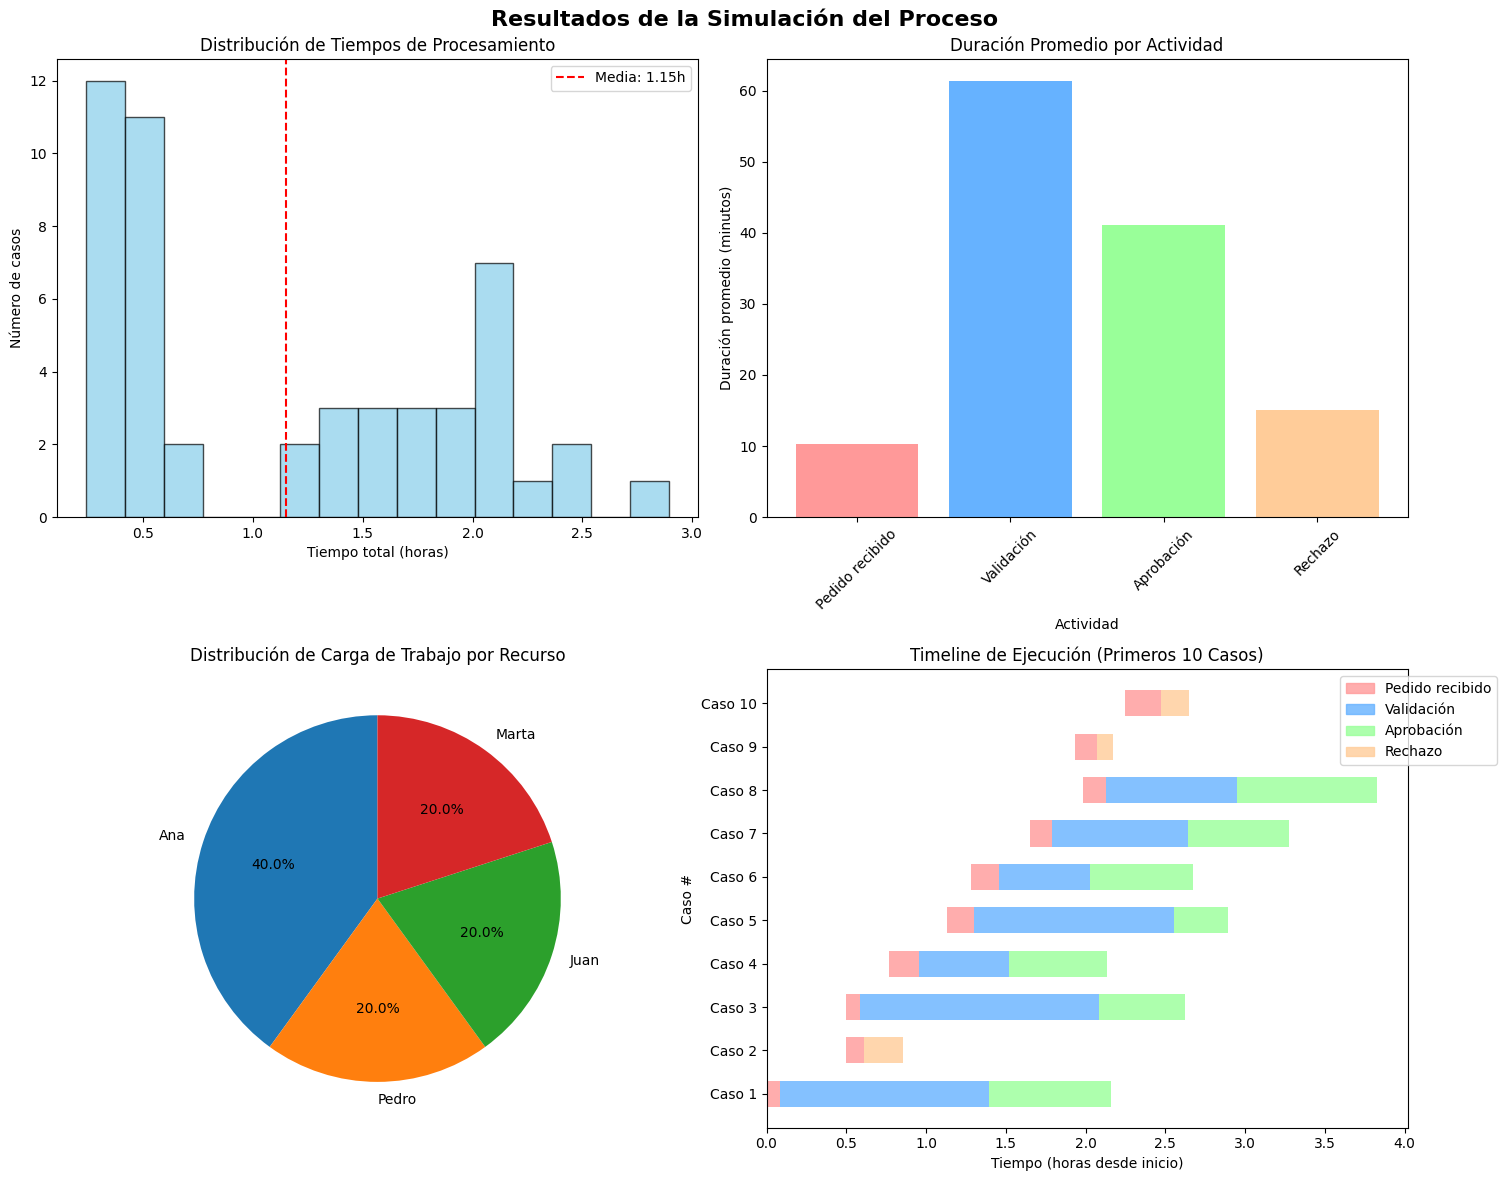


📈 Gráficos de simulación guardados como 'simulacion_resultados.png'


In [111]:
# Visualizaciones de la simulación
plt.style.use('default')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Resultados de la Simulación del Proceso', fontsize=16, fontweight='bold')

# 1. Distribución de tiempos de casos
ax1.hist(tiempos_horas, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Tiempo total (horas)')
ax1.set_ylabel('Número de casos')
ax1.set_title('Distribución de Tiempos de Procesamiento')
ax1.axvline(np.mean(tiempos_horas), color='red', linestyle='--', label=f'Media: {np.mean(tiempos_horas):.2f}h')
ax1.legend()

# 2. Duración promedio por actividad
actividades_nombres = list(actividades_stats.keys())
actividades_promedios = [np.mean(duraciones)/60 for duraciones in actividades_stats.values()]

ax2.bar(actividades_nombres, actividades_promedios, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
ax2.set_xlabel('Actividad')
ax2.set_ylabel('Duración promedio (minutos)')
ax2.set_title('Duración Promedio por Actividad')
ax2.tick_params(axis='x', rotation=45)

# 3. Carga de trabajo por recurso
recursos_nombres = list(recursos_stats.keys())
recursos_cargas = [len(duraciones) for duraciones in recursos_stats.values()]

ax3.pie(recursos_cargas, labels=recursos_nombres, autopct='%1.1f%%', startangle=90)
ax3.set_title('Distribución de Carga de Trabajo por Recurso')

# 4. Timeline de casos (primeros 10 casos)
colores_actividades = {
    'Pedido recibido': '#FF9999',
    'Validación': '#66B2FF', 
    'Aprobación': '#99FF99',
    'Rechazo': '#FFCC99'
}

for i, caso in enumerate(casos_simulados[:10]):
    if caso['estado'] == 'completado':
        for j, actividad in enumerate(caso['actividades']):
            inicio = actividad['tiempo_inicio']
            duracion = actividad['duracion'] / 3600  # convertir a horas
            ax4.barh(i, duracion, left=(inicio - casos_simulados[0]['tiempo_llegada']).total_seconds()/3600, 
                    color=colores_actividades.get(actividad['actividad'], 'gray'), 
                    alpha=0.8, height=0.6)

ax4.set_xlabel('Tiempo (horas desde inicio)')
ax4.set_ylabel('Caso #')
ax4.set_title('Timeline de Ejecución (Primeros 10 Casos)')
ax4.set_yticks(range(10))
ax4.set_yticklabels([f"Caso {i+1}" for i in range(10)])

# Leyenda para el timeline
legend_elements = [plt.Rectangle((0,0),1,1, color=color, alpha=0.8, label=actividad) 
                  for actividad, color in colores_actividades.items()]
ax4.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.savefig('simulacion_resultados.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📈 Gráficos de simulación guardados como 'simulacion_resultados.png'")

In [112]:
# Exportar resultados de la simulación
print("=== EXPORTACIÓN DE RESULTADOS ===")

# 1. Crear DataFrame con eventos simulados
eventos_df = pd.DataFrame([
    {
        'caso_id': evento['caso_id'],
        'actividad': evento['actividad'],
        'recurso': evento['recurso'],
        'tiempo_inicio': evento['tiempo_inicio'],
        'tiempo_fin': evento['tiempo_fin'],
        'duracion_segundos': evento['duracion'],
        'duracion_minutos': evento['duracion'] / 60
    }
    for evento in eventos_simulados
])

# 2. Crear DataFrame con resumen de casos
casos_df = pd.DataFrame([
    {
        'caso_id': caso['id'],
        'tiempo_llegada': caso['tiempo_llegada'],
        'num_actividades': len(caso['actividades']),
        'tiempo_total_segundos': caso['tiempo_total'],
        'tiempo_total_horas': caso['tiempo_total'] / 3600,
        'estado': caso['estado'],
        'variante': ' → '.join([act['actividad'] for act in caso['actividades']]) if caso['actividades'] else 'Sin actividades'
    }
    for caso in casos_simulados
])

# 3. Crear DataFrame con métricas resumen
metricas_df = pd.DataFrame([
    {'Métrica': 'Casos totales simulados', 'Valor': len(casos_simulados), 'Unidad': 'casos'},
    {'Métrica': 'Casos completados', 'Valor': len([c for c in casos_simulados if c['estado'] == 'completado']), 'Unidad': 'casos'},
    {'Métrica': 'Tiempo promedio por caso', 'Valor': round(np.mean(tiempos_horas), 2), 'Unidad': 'horas'},
    {'Métrica': 'Tiempo máximo por caso', 'Valor': round(np.max(tiempos_horas), 2), 'Unidad': 'horas'},
    {'Métrica': 'Tiempo mínimo por caso', 'Valor': round(np.min(tiempos_horas), 2), 'Unidad': 'horas'},
    {'Métrica': 'Throughput promedio', 'Valor': round(len(casos_simulados) / (max(tiempos_casos) / 3600), 2), 'Unidad': 'casos/hora'},
    {'Métrica': 'Variantes diferentes', 'Valor': len(variantes_simuladas), 'Unidad': 'variantes'},
    {'Métrica': 'Recursos utilizados', 'Valor': len(recursos_stats), 'Unidad': 'recursos'}
])

# 4. Guardar archivos
eventos_df.to_csv('simulacion_eventos.csv', index=False)
casos_df.to_csv('simulacion_casos.csv', index=False)
metricas_df.to_csv('simulacion_metricas.csv', index=False)

print("\n📁 Archivos exportados:")
print("   ✓ simulacion_eventos.csv - Detalle de todos los eventos simulados")
print("   ✓ simulacion_casos.csv - Resumen por caso")
print("   ✓ simulacion_metricas.csv - Métricas agregadas")
print("   ✓ simulacion_resultados.png - Gráficos de análisis")

# 5. Mostrar resumen final
print("\n" + "="*60)
print("🎯 RESUMEN EJECUTIVO DE LA SIMULACIÓN")
print("="*60)
print(f"📊 Se simularon {len(casos_simulados)} casos del proceso")
print(f"⏱️  Tiempo promedio de procesamiento: {np.mean(tiempos_horas):.2f} horas")
print(f"🔄 Se identificaron {len(variantes_simuladas)} variantes diferentes del proceso")
print(f"👥 Se utilizaron {len(recursos_stats)} recursos diferentes")
print(f"\n🏆 Actividad más frecuente: {max(actividades_stats.keys(), key=lambda k: len(actividades_stats[k]))}")
print(f"⚡ Recurso más utilizado: {max(recursos_stats.keys(), key=lambda k: len(recursos_stats[k]))}")

print("\n💡 Conclusiones:")
if np.mean(tiempos_horas) < 2:
    print("   ✅ El proceso es eficiente con tiempos de respuesta bajos")
else:
    print("   ⚠️  El proceso podría beneficiarse de optimizaciones")

if len(variantes_simuladas) <= 2:
    print("   ✅ El proceso es consistente con pocas variantes")
else:
    print("   ⚠️  El proceso tiene múltiples variantes, revisar estandarización")

print("\n🚀 La simulación proporciona una base sólida para la optimización del proceso")
print("="*60)

=== EXPORTACIÓN DE RESULTADOS ===

📁 Archivos exportados:
   ✓ simulacion_eventos.csv - Detalle de todos los eventos simulados
   ✓ simulacion_casos.csv - Resumen por caso
   ✓ simulacion_metricas.csv - Métricas agregadas
   ✓ simulacion_resultados.png - Gráficos de análisis

🎯 RESUMEN EJECUTIVO DE LA SIMULACIÓN
📊 Se simularon 50 casos del proceso
⏱️  Tiempo promedio de procesamiento: 1.15 horas
🔄 Se identificaron 2 variantes diferentes del proceso
👥 Se utilizaron 4 recursos diferentes

🏆 Actividad más frecuente: Pedido recibido
⚡ Recurso más utilizado: Ana

💡 Conclusiones:
   ✅ El proceso es eficiente con tiempos de respuesta bajos
   ✅ El proceso es consistente con pocas variantes

🚀 La simulación proporciona una base sólida para la optimización del proceso


# 6. Process Enhancement - Mejora de Procesos

El **Process Enhancement** es el tercer pilar del process mining. Una vez que hemos:
1. **Descubierto** nuestro proceso (Discovery)
2. **Verificado** su conformidad (Conformance)

Ahora podemos **mejorarlo** usando técnicas de enhancement.

PM4py ofrece varias capacidades nativas para mejorar procesos:
- **Análisis de performance**: Identificar cuellos de botella
- **Análisis de recursos**: Optimizar asignación de recursos
- **Predicción**: Predecir problemas antes de que ocurran
- **Recomendaciones**: Sugerir próximas actividades óptimas
- **Optimización**: Encontrar variantes más eficientes

## Enhancement con PM4py: Performance Spectrum

Vamos a utilizar el módulo de performance spectrum de pm4py para identificar cuellos de botella y analizar los tiempos de espera entre actividades.

In [ ]:
from pm4py.statistics.performance_spectrum import performance_spectrum
import matplotlib.pyplot as plt
import pandas as pd

# Calculamos el performance spectrum del log
enhancement_ps = performance_spectrum.apply(log)

# Mostramos el performance spectrum como DataFrame
ps_df = pd.DataFrame(enhancement_ps)
print("Performance Spectrum (tiempos entre actividades):")
print(ps_df.head())

# Visualización de los tiempos de espera entre actividades
if not ps_df.empty:
    plt.figure(figsize=(10,6))
    for act_pair in ps_df['activity_pair'].unique():
        subset = ps_df[ps_df['activity_pair'] == act_pair]
        plt.scatter([act_pair]*len(subset), subset['value'], alpha=0.5)
    plt.ylabel('Tiempo entre actividades (segundos)')
    plt.xlabel('Transición')
    plt.title('Performance Spectrum: Tiempos entre actividades')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No se pudo calcular el performance spectrum para este log.")

: 